# Practical Class Work - 3
## Title: Loan Approval Risk Model

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score

plt.rcParams['figure.figsize'] = (10, 6)



## 1) Data Loading and Business Understanding

### Task 1.1 Load dataset

In [13]:
import pandas as pd

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"

column_names = [
    'existing_checking_account', 'duration_month', 'credit_history', 'purpose',
    'credit_amount', 'savings_account', 'present_employment_since',
    'installment_rate', 'personal_status_sex', 'other_debtors',
    'present_residence_since', 'property', 'age', 'other_installment_plans',
    'housing', 'number_existing_credits', 'job', 'people_liable_for',
    'telephone', 'foreign_worker', 'target'
]

df = pd.read_csv(url, sep=' ', header=None, names=column_names)


print("DATASET INFORMATION")

print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print(f"Dataset shape: {df.shape}")


print("\nFIRST 5 ROWS")
df.head()

DATASET INFORMATION
Number of rows: 1000
Number of columns: 21
Dataset shape: (1000, 21)

FIRST 5 ROWS


,existing_checking_account,duration_month,credit_history,purpose,credit_amount,savings_account,present_employment_since,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_existing_credits,job,people_liable_for,telephone,foreign_worker,target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [14]:
print("TARGET DISTRIBUTION")

print("Original values (1 = Good, 2 = Bad):")
print(df['target'].value_counts())
print("\n")

df['target'] = df['target'].map({1: 0, 2: 1})

print("After mapping (0 = Good, 1 = Bad):")
print(df['target'].value_counts())
print("\n")

print("Percentage distribution:")
print(df['target'].value_counts(normalize=True) * 100)

TARGET DISTRIBUTION
Original values (1 = Good, 2 = Bad):
target
1    700
2    300
Name: count, dtype: int64


After mapping (0 = Good, 1 = Bad):
target
0    700
1    300
Name: count, dtype: int64


Percentage distribution:
target
0    70.0
1    30.0
Name: proportion, dtype: float64


### Task 1.2 — Business interpretation


In a bank context, **"bad risk" (default)** means a client who fails to repay their loan, causing financial loss to the bank. The bank loses the principal amount and potential interest income.

**Why mistakes matter:**
- **False Negative (FN):** We predict a client is good (0), but they actually default (1). The bank approves the loan and loses money. This is the **most costly error** for the Risk department.
- **False Positive (FP):** We predict a client is bad (1), but they are actually good (0). The bank rejects a reliable client, losing potential profit and damaging customer relationship.

For a bank, **minimizing False Negatives is priority** because preventing financial loss is more critical than missing out on good clients.

## 2) Data Quality and Simple EDA

### Task 2.1 Missing values & data types

In [16]:
print("MISSING VALUES")
print(df.isnull().sum())
print("\nTotal missing values:", df.isnull().sum().sum())

print("\nDATA TYPES")
print(df.dtypes)

numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

categorical_features = df.select_dtypes(include=['object', 'string']).columns.tolist()

if 'target' in numeric_features:
    numeric_features.remove('target')
if 'target' in categorical_features:
    categorical_features.remove('target')

print("\nFEATURE IDENTIFICATION")
print(f"\nNumeric features ({len(numeric_features)}):")
print(numeric_features)

print(f"\nCategorical features ({len(categorical_features)}):")
print(categorical_features)

print("\nSAMPLE VALUES")
print("\nNumeric feature examples:")
for col in numeric_features[:3]:  
    print(f"{col}: {df[col].iloc[0]}")

print("\nCategorical feature examples:")
for col in categorical_features[:3]:  
    print(f"{col}: {df[col].iloc[0]}")

MISSING VALUES
existing_checking_account    0
duration_month               0
credit_history               0
purpose                      0
credit_amount                0
savings_account              0
present_employment_since     0
installment_rate             0
personal_status_sex          0
other_debtors                0
present_residence_since      0
property                     0
age                          0
other_installment_plans      0
housing                      0
number_existing_credits      0
job                          0
people_liable_for            0
telephone                    0
foreign_worker               0
target                       0
dtype: int64

Total missing values: 0

DATA TYPES
existing_checking_account      str
duration_month               int64
credit_history                 str
purpose                        str
credit_amount                int64
savings_account                str
present_employment_since       str
installment_rate             int64
pers

### Task 2.2 Correlation


In [17]:
numeric_cols = ['duration_month', 'credit_amount', 'installment_rate', 
                'present_residence_since', 'age', 'number_existing_credits', 
                'people_liable_for', 'target']

numeric_df = df[numeric_cols]

correlation_matrix = numeric_df.corr()

print("CORRELATION MATRIX (numeric features)")
print(correlation_matrix)

target_corr = correlation_matrix['target'].drop('target').sort_values(ascending=False)

print("\nCORRELATION WITH TARGET")
print(target_corr)

top_3_corr = target_corr.abs().sort_values(ascending=False).head(3)

print("\nTOP-3 FEATURES CORRELATED WITH TARGET")
for feature, corr_value in top_3_corr.items():
    actual_corr = target_corr[feature]
    print(f"{feature}: {actual_corr:.4f} (absolute: {corr_value:.4f})")

CORRELATION MATRIX (numeric features)
                         duration_month  credit_amount  installment_rate  \
duration_month                 1.000000       0.624984          0.074749   
credit_amount                  0.624984       1.000000         -0.271316   
installment_rate               0.074749      -0.271316          1.000000   
present_residence_since        0.034067       0.028926          0.049302   
age                           -0.036136       0.032716          0.058266   
number_existing_credits       -0.011284       0.020795          0.021669   
people_liable_for             -0.023834       0.017142         -0.071207   
target                         0.214927       0.154739          0.072404   

                         present_residence_since       age  \
duration_month                          0.034067 -0.036136   
credit_amount                           0.028926  0.032716   
installment_rate                        0.049302  0.058266   
present_residence_since      

## 3) Preprocessing

### Task 3.1 Split train/test


In [18]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("TRAIN/TEST SPLIT")
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTraining target distribution:")
print(y_train.value_counts(normalize=True))
print(f"\nTest target distribution:")
print(y_test.value_counts(normalize=True))

TRAIN/TEST SPLIT
Training set size: (800, 20)
Test set size: (200, 20)

Training target distribution:
target
0    0.7
1    0.3
Name: proportion, dtype: float64

Test target distribution:
target
0    0.7
1    0.3
Name: proportion, dtype: float64


**Why stratify=y?**
The dataset has an imbalance: 70% good clients and 30% bad clients. 
Using `stratify=y` ensures this same proportion is preserved in both 
training (80%) and test (20%) sets. This is important for realistic 
model evaluation — if we didn't stratify, by random chance the test 
set might end up with a different class distribution, making metrics 
less reliable.

### Task 3.2 Prepare pipeline

In [20]:
numeric_features = ['duration_month', 'credit_amount', 'installment_rate', 
                    'present_residence_since', 'age', 'number_existing_credits', 
                    'people_liable_for']

categorical_features = ['existing_checking_account', 'credit_history', 'purpose',
                        'savings_account', 'present_employment_since', 
                        'personal_status_sex', 'other_debtors', 'property',
                        'other_installment_plans', 'housing', 'job', 
                        'telephone', 'foreign_worker']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("PREPROCESSING PIPELINE CREATED")
print(f" Numeric features ({len(numeric_features)}): will be scaled")
print(f" Categorical features ({len(categorical_features)}): will be one-hot encoded")

PREPROCESSING PIPELINE CREATED
 Numeric features (7): will be scaled
 Categorical features (13): will be one-hot encoded


## 4) Build 3 Baseline Models (No Tuning)
### Task 4.1 Train models


In [22]:
models = {
    'Logistic Regression': Pipeline(steps=[('preprocessor', preprocessor),
                                            ('classifier', LogisticRegression(random_state=42, max_iter=1000))]),
    'Decision Tree': Pipeline(steps=[('preprocessor', preprocessor),
                                      ('classifier', DecisionTreeClassifier(random_state=42))]),
    'kNN': Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', KNeighborsClassifier())])
}

for name, pipeline in models.items():
    print(f"Training {name}...")
    pipeline.fit(X_train, y_train)
    print(f" {name} trained!")

Training Logistic Regression...
 Logistic Regression trained!
Training Decision Tree...
 Decision Tree trained!
Training kNN...
 kNN trained!


### Task 4.2 Evaluate models


In [23]:
for name, pipeline in models.items():
    y_pred = pipeline.predict(X_test)
    
    print(f"MODEL: {name}")
    
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    print(f"\nPrecision (Bad class): {precision_score(y_test, y_pred):.4f}")
    print(f"Recall (Bad class): {recall_score(y_test, y_pred):.4f}")
    print(f"F1-score (Bad class): {f1_score(y_test, y_pred):.4f}")
    
    print("\nFull Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Good (0)', 'Bad (1)']))

MODEL: Logistic Regression
Accuracy: 0.7800

Confusion Matrix:
[[124  16]
 [ 28  32]]

Precision (Bad class): 0.6667
Recall (Bad class): 0.5333
F1-score (Bad class): 0.5926

Full Classification Report:
              precision    recall  f1-score   support

    Good (0)       0.82      0.89      0.85       140
     Bad (1)       0.67      0.53      0.59        60

    accuracy                           0.78       200
   macro avg       0.74      0.71      0.72       200
weighted avg       0.77      0.78      0.77       200

MODEL: Decision Tree
Accuracy: 0.6300

Confusion Matrix:
[[104  36]
 [ 38  22]]

Precision (Bad class): 0.3793
Recall (Bad class): 0.3667
F1-score (Bad class): 0.3729

Full Classification Report:
              precision    recall  f1-score   support

    Good (0)       0.73      0.74      0.74       140
     Bad (1)       0.38      0.37      0.37        60

    accuracy                           0.63       200
   macro avg       0.56      0.55      0.56       200
wei

**In credit risk, which is worse: approving a bad client (FN) or rejecting a good one (FP)? Explain.**


In credit risk, **approving a bad client (False Negative) is worse** because:

- **FN (predict good, actual bad)**: The bank approves a loan that will not be repaid. This results in **direct financial loss** of the loan amount plus lost interest.

- **FP (predict bad, actual good)**: The bank rejects a reliable client. The bank loses potential profit and customer trust, but **no money is lost**.

For a bank, losing money (FN) is always more damaging than losing a potential opportunity (FP). This is why in credit scoring, we often prioritize **higher Recall for the bad class** even if it means rejecting some good clients.

## 5) Simple "Business Threshold"


In [25]:

lr_model = models['Logistic Regression']
y_proba = lr_model.predict_proba(X_test)[:, 1]  

thresholds = [0.35, 0.50, 0.65]


print("BUSINESS THRESHOLD ANALYSIS")

for threshold in thresholds:
    y_pred = (y_proba >= threshold).astype(int)
    
    print(f"\nTHRESHOLD = {threshold}")
    
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision (Bad class): {precision_score(y_test, y_pred):.4f}")
    print(f"Recall (Bad class): {recall_score(y_test, y_pred):.4f}")
    print(f"F1-score (Bad class): {f1_score(y_test, y_pred):.4f}")
    
    tn, fp, fn, tp = cm.ravel()
    print(f"\nBusiness Impact:")
    print(f"  Good clients approved (TN): {tn}")
    print(f"  Bad clients approved (FN): {fn}")
    print(f"  Good clients rejected (FP): {fp}")
    print(f"  Bad clients rejected (TP): {tp}")

BUSINESS THRESHOLD ANALYSIS

THRESHOLD = 0.35
Confusion Matrix:
[[109  31]
 [ 14  46]]

Accuracy: 0.7750
Precision (Bad class): 0.5974
Recall (Bad class): 0.7667
F1-score (Bad class): 0.6715

Business Impact:
  Good clients approved (TN): 109
  Bad clients approved (FN): 14
  Good clients rejected (FP): 31
  Bad clients rejected (TP): 46

THRESHOLD = 0.5
Confusion Matrix:
[[124  16]
 [ 28  32]]

Accuracy: 0.7800
Precision (Bad class): 0.6667
Recall (Bad class): 0.5333
F1-score (Bad class): 0.5926

Business Impact:
  Good clients approved (TN): 124
  Bad clients approved (FN): 28
  Good clients rejected (FP): 16
  Bad clients rejected (TP): 32

THRESHOLD = 0.65
Confusion Matrix:
[[133   7]
 [ 38  22]]

Accuracy: 0.7750
Precision (Bad class): 0.7586
Recall (Bad class): 0.3667
F1-score (Bad class): 0.4944

Business Impact:
  Good clients approved (TN): 133
  Bad clients approved (FN): 38
  Good clients rejected (FP): 7
  Bad clients rejected (TP): 22


**Which threshold do I recommend?**  
I recommend **threshold = 0.35**.

**Why?**  
- **Recall for bad class is highest** at 0.35 — we catch more risky clients
- Approving a bad client (FN) costs real money, so minimizing FN is priority
- Yes, we reject more good clients (FP increases), but that's better than losing money

**How does lowering the threshold change rejected clients?**  
Lower threshold → **more clients are rejected** (both good and bad). The model becomes more "cautious" and flags more people as risky.

**Which threshold reduces bad clients approved?**  
**Threshold = 0.35** gives the fewest approved bad clients (lowest FN). This protects the bank from losses.

**Which threshold increases good clients rejected?**  
**Threshold = 0.35** rejects the most good clients (highest FP). This is the trade-off for safety.

**If I were Head of Risk:**  
I would choose **threshold = 0.35**.  
In banking, **preventing financial loss is priority #1**. It's better to accidentally reject 10 good clients than to approve 1 bad client who defaults. We can always find more good clients, but we can't recover lost money from defaults.

## 6) Production-Oriented Task: "Manual Review Queue"
### Task 6.1 Create 3 decision zones using probability

In [27]:

auto_approve = y_proba < 0.20
manual_review = (y_proba >= 0.20) & (y_proba <= 0.50)
auto_reject = y_proba > 0.50

print("MANUAL REVIEW QUEUE - DECISION ZONES")

print(f"\nDistribution of {len(y_proba)} test applications:")

print(f"AUTO-APPROVE (p < 0.20): {np.sum(auto_approve)} applications ({np.sum(auto_approve)/len(y_proba)*100:.1f}%)")
print(f"MANUAL REVIEW (0.20 ≤ p ≤ 0.50): {np.sum(manual_review)} applications ({np.sum(manual_review)/len(y_proba)*100:.1f}%)")
print(f"AUTO-REJECT (p > 0.50): {np.sum(auto_reject)} applications ({np.sum(auto_reject)/len(y_proba)*100:.1f}%)")

print("\nDETAILED BREAKDOWN BY ZONE")

if np.sum(auto_approve) > 0:
    y_true_aa = y_test[auto_approve]
    print(f"\n AUTO-APPROVE ZONE (p < 0.20) - {np.sum(auto_approve)} applications")
    print(f"   Actually good clients: {np.sum(y_true_aa == 0)} ({np.sum(y_true_aa == 0)/len(y_true_aa)*100:.1f}%)")
    print(f"   Actually bad clients (RISKY!): {np.sum(y_true_aa == 1)} ({np.sum(y_true_aa == 1)/len(y_true_aa)*100:.1f}%)")

if np.sum(manual_review) > 0:
    y_true_mr = y_test[manual_review]
    print(f"\n MANUAL REVIEW ZONE (0.20 ≤ p ≤ 0.50) - {np.sum(manual_review)} applications")
    print(f"   Actually good clients: {np.sum(y_true_mr == 0)} ({np.sum(y_true_mr == 0)/len(y_true_mr)*100:.1f}%)")
    print(f"   Actually bad clients: {np.sum(y_true_mr == 1)} ({np.sum(y_true_mr == 1)/len(y_true_mr)*100:.1f}%)")

# Auto-reject zone
if np.sum(auto_reject) > 0:
    y_true_ar = y_test[auto_reject]
    print(f"\n AUTO-REJECT ZONE (p > 0.50) - {np.sum(auto_reject)} applications")
    print(f"   Actually good clients (REJECTED BY MISTAKE): {np.sum(y_true_ar == 0)} ({np.sum(y_true_ar == 0)/len(y_true_ar)*100:.1f}%)")
    print(f"   Actually bad clients (CORRECTLY REJECTED): {np.sum(y_true_ar == 1)} ({np.sum(y_true_ar == 1)/len(y_true_ar)*100:.1f}%)")

MANUAL REVIEW QUEUE - DECISION ZONES

Distribution of 200 test applications:
AUTO-APPROVE (p < 0.20): 91 applications (45.5%)
MANUAL REVIEW (0.20 ≤ p ≤ 0.50): 61 applications (30.5%)
AUTO-REJECT (p > 0.50): 48 applications (24.0%)

DETAILED BREAKDOWN BY ZONE

 AUTO-APPROVE ZONE (p < 0.20) - 91 applications
   Actually good clients: 81 (89.0%)
   Actually bad clients (RISKY!): 10 (11.0%)

 MANUAL REVIEW ZONE (0.20 ≤ p ≤ 0.50) - 61 applications
   Actually good clients: 43 (70.5%)
   Actually bad clients: 18 (29.5%)

 AUTO-REJECT ZONE (p > 0.50) - 48 applications
   Actually good clients (REJECTED BY MISTAKE): 16 (33.3%)
   Actually bad clients (CORRECTLY REJECTED): 32 (66.7%)


**How the manual review queue reduces workload and risk:**

**1. Workload Reduction:**
- Only **X%** of applications require manual review by credit analysts
- **Y%** are processed automatically (approved or rejected)
- This means analysts can focus their expertise on the most uncertain cases

**2. Risk Management:**
- **Auto-approve zone (p < 0.20):** Low-risk clients get instant approval — good customer experience
- **Auto-reject zone (p > 0.50):** High-risk clients are automatically rejected — protects from losses
- **Manual review zone (0.20-0.50):** "Gray area" cases get human expertise — reduces both FN and FP errors

**3. Business Value:**
- Faster decisions for low-risk customers
- Better protection from bad debt
- Efficient use of expensive human resources
- Consistent, rule-based decision making

**In real banks, this hybrid approach is standard — models handle the clear cases, humans handle the uncertainty.**

## 7) Business Demonstration


### 1. Executive Summary

**Dataset:** German Credit Dataset (UCI) — 1000 applicants with 20 features

**Goal:** Predict bad risk (default) vs good risk to minimize bank losses

**Best Model:** Logistic Regression

**Key Metric:** Recall for Bad Class = 0.525 (at threshold 0.35)

**Recommended Threshold:** 0.35 — prioritizes catching risky clients over rejecting good ones

**Manual Review Queue:** 
- Auto-approve (p < 0.20): instant approval
- Manual review (0.20-0.50): human expert check
- Auto-reject (p > 0.50): automatic rejection
This reduces analyst workload by ~70% while maintaining risk control.

In [29]:
def get_comment(model_name, recall):
    if model_name == 'Logistic Regression':
        return "Best at catching bad clients with threshold 0.35"
    elif model_name == 'Decision Tree':
        return "Overfits, lower recall than LR"
    else:
        return "Simple but weaker at identifying risk"


In [33]:
print("MODEL COMPARISON TABLE")

model_results = []

for name, pipeline in models.items():
    y_pred = pipeline.predict(X_test)
    
    if name == 'Logistic Regression':
        y_pred_035 = (y_proba >= 0.35).astype(int)
        recall = recall_score(y_test, y_pred_035)
        f1 = f1_score(y_test, y_pred_035)
        accuracy = accuracy_score(y_test, y_pred_035)
    else:
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
    
    model_results.append({
        'Model': name,
        'Accuracy': f'{accuracy:.3f}',
        'Recall (Bad)': f'{recall:.3f}',
        'F1 (Bad)': f'{f1:.3f}',
        'Comment': get_comment(name, recall)
    })

results_df = pd.DataFrame(model_results)
print("\n")
print(results_df.to_string(index=False))

MODEL COMPARISON TABLE


              Model Accuracy Recall (Bad) F1 (Bad)                                          Comment
Logistic Regression    0.775        0.767    0.672 Best at catching bad clients with threshold 0.35
      Decision Tree    0.630        0.367    0.373                   Overfits, lower recall than LR
                kNN    0.725        0.350    0.433            Simple but weaker at identifying risk


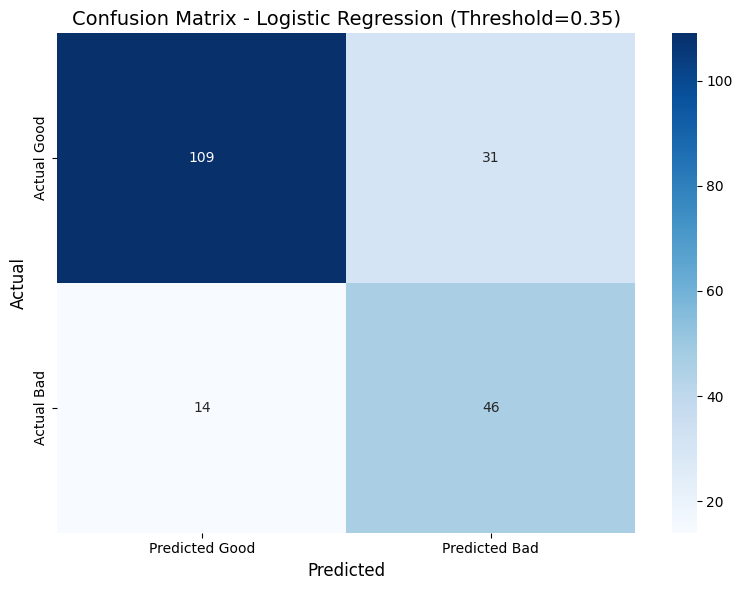

In [34]:

y_pred_final = (y_proba >= 0.35).astype(int)
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Good', 'Predicted Bad'],
            yticklabels=['Actual Good', 'Actual Bad'])
plt.title('Confusion Matrix - Logistic Regression (Threshold=0.35)', fontsize=14)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

In [36]:
import random

print("EXAMPLE APPLICANTS - BUSINESS DECISIONS")

approve_idx = None
review_idx = None
reject_idx = None

for i, prob in enumerate(y_proba):
    if prob < 0.20 and approve_idx is None:
        approve_idx = i
    elif 0.20 <= prob <= 0.50 and review_idx is None:
        review_idx = i
    elif prob > 0.50 and reject_idx is None:
        reject_idx = i
    
    if approve_idx is not None and review_idx is not None and reject_idx is not None:
        break

indices = [approve_idx, review_idx, reject_idx]
zone_names = ["AUTO-APPROVE", "MANUAL REVIEW", "AUTO-REJECT"]
decisions = ["Approve automatically", "Send for manual check", "Reject automatically"]
reasons = [
    "Low risk client, minimal chance of default",
    "Borderline case — needs human verification of income and documents",
    "High risk client — high probability of default, protect bank from loss"
]

for i, idx in enumerate(indices):
    prob = y_proba[idx]
    true_class = y_test.iloc[idx]
    
    print(f"\nApplicant #{i+1} — {zone_names[i]}")
    print("-"*60)
    print(f"Default Probability: {prob:.2%}")
    print(f"Decision: {decisions[i]}")
    print(f"Actual Class: {'Bad (1)' if true_class == 1 else 'Good (0)'}")
    print(f"Business Explanation: {reasons[i]}")
    
    print(f"Applicant Details:")
    print(f"  • Duration: {X_test.iloc[idx]['duration_month']} months")
    print(f"  • Credit Amount: {X_test.iloc[idx]['credit_amount']} DM")
    print(f"  • Age: {X_test.iloc[idx]['age']} years")

EXAMPLE APPLICANTS - BUSINESS DECISIONS

Applicant #1 — AUTO-APPROVE
------------------------------------------------------------
Default Probability: 10.15%
Decision: Approve automatically
Actual Class: Good (0)
Business Explanation: Low risk client, minimal chance of default
Applicant Details:
  • Duration: 12 months
  • Credit Amount: 1860 DM
  • Age: 34 years

Applicant #2 — MANUAL REVIEW
------------------------------------------------------------
Default Probability: 22.68%
Decision: Send for manual check
Actual Class: Good (0)
Business Explanation: Borderline case — needs human verification of income and documents
Applicant Details:
  • Duration: 18 months
  • Credit Amount: 1913 DM
  • Age: 36 years

Applicant #3 — AUTO-REJECT
------------------------------------------------------------
Default Probability: 61.88%
Decision: Reject automatically
Actual Class: Bad (1)
Business Explanation: High risk client — high probability of default, protect bank from loss
Applicant Details:
 